# Estimating Wildfire Smoke Impact for Tallahassee
.
### Problem Statement
The goal of this analysis is to develop an estimate of wildfire smoke reaTallahassee City] each year ba historic ed on wildfire data, which includes attributes such as the size of the fire, proximity to the city, and the year in which it occufires.

### Key Questions and Decisions
To construct a reliable smoke estimate, several key questions must be addressed:
- **Defining the Smoke Estimate**: What factors should be included in the smoke impact calculation? For instance, should both the fire size (in acres burned) and the distance to the city beccordingly.
  
### Approach
1. **Define the Smoke Estimate Metric**: Based on factors such as acreage burned, fire duration, and distance to the city, we will develop a calculation method to approximate the smoke impact for eac650 miles of Tallahasseeified distance.
2. **Annual Aggregation** create an annual aggregation of smoke imapct for the prediction model.

### Notebook Outline
1. **Data Preparation**: Load and prepare wildfire data for analysis, ensuring that we have relevant attributes like fire size, location, distance from the city, and year.
2. **Defining the Smoke Estimate Calculation**: Outline the formula used to calculate smoke impact and document the reasoning behind selected factors.
3. **Applying the Smoke Estimate**: Apply the smoke estimate to each fire within 650 miles of Tallahassee distance 
4. **Predicition Models**: Use the historical annual smoke impact estimate to predict smoke impact 20 years into the future.

Imports

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

### Load Data

In [2]:
csvs_path = r"C:\Users\clark.roll\python coding\code_personal\Data512\Course Project\Part 1\intermediate files"

# Calculated Distances
distances_csv = 'fire_distances.csv'
csv_filepath = os.path.join(csvs_path, distances_csv)
distances_df= pd.read_csv(csv_filepath)

# Wildfire Metadata
metadata_csv = 'Wildland_Fire_Combined_Subset.csv'
csv_filepath = os.path.join(csvs_path, metadata_csv)
metadata_df= pd.read_csv(csv_filepath)

# EPA AQI Readings
aqi_csv = 'subset_aqi_data.csv'
csv_filepath = os.path.join(csvs_path, aqi_csv)
aqi_df= pd.read_csv(csv_filepath)

### Prepare Data

Lets merge the wildfire distances and metadata using `usgs_assignend_id` as the merge field

In [3]:
# reduce so there aren't redundant columns

distances_subset = distances_df[['usgs_assigned_id',
                                 'closest_distance_miles','average_distance_miles',
                                 'closest_point_lat', 'closest_point_lon']].copy()

metadata_df = metadata_df[metadata_df['duration_days'] >= 0]

# Ensure the key columns have the same name for joining
distances_subset = distances_subset.rename(columns={'usgs_assigned_id': 'USGS_Assigned_ID'})

# Perform a left join on 'USGS_Assigned_ID'
merged_df = distances_subset.merge(metadata_df, on='USGS_Assigned_ID', how='left')

In [4]:
merged_df

,USGS_Assigned_ID,closest_distance_miles,average_distance_miles,closest_point_lat,closest_point_lon,Assigned_Fire_Type,Fire_Year,Trusted_Start_Date,Trusted_End_Date,duration_days,GIS_Acres
0,13526,2212.293403,2218.332334,40.310411,-121.895451,Wildfire,1961.0,1961-09-08,1961-10-31,53.0,55249.740141
1,13527,2077.348836,2078.078157,37.268174,-119.675518,Wildfire,1961.0,1961-07-10,1961-10-31,113.0,43920.841077
2,13528,2135.116430,2142.401009,38.447980,-120.652318,Wildfire,1961.0,1961-09-02,1961-10-31,59.0,34233.698603
3,13529,2169.219255,2175.600421,37.233625,-121.344383,Wildfire,1961.0,1961-07-12,1961-10-31,111.0,32866.053451
4,13530,2139.278205,2142.886328,44.922865,-119.253744,Wildfire,1961.0,1961-09-01,1961-10-31,60.0,27269.045936
...,...,...,...,...,...,...,...,...,...,...,...
53925,135010,1783.951846,1784.887371,44.448183,-111.836191,Prescribed Fire,2020.0,2020-05-01,2020-07-30,90.0,4143.012270
53926,135017,1264.020411,1264.500292,33.514535,-105.514613,Prescribed Fire,2020.0,2020-08-12,2020-08-20,8.0,206.093386
53927,135028,2258.237344,2258.425715,40.649556,-122.726618,Prescribed Fire,2020.0,2020-05-01,2020-05-02,1.0,77.245054
53928,135047,2080.377015,2080.544867,47.490303,-116.670445,Prescribed Fire,2020.0,2020-06-20,2020-10-31,133.0,19.824395


Lets clean up this dataframe- looks like there are some NaNs that we wont want to work with

In [5]:
nan_counts = merged_df.isna().sum()
print(nan_counts)

USGS_Assigned_ID            0
closest_distance_miles      0
average_distance_miles      0
closest_point_lat           0
closest_point_lon           0
Assigned_Fire_Type        313
Fire_Year                 313
Trusted_Start_Date        313
Trusted_End_Date          313
duration_days             313
GIS_Acres                 313
dtype: int64


In [6]:
cleaned_merged = merged_df.dropna(subset=['Assigned_Fire_Type',
                                          'Trusted_Start_Date', 'Trusted_End_Date',
                                          'duration_days','GIS_Acres']).copy()

cleaned_merged['Fire_Year'] = pd.to_datetime(cleaned_merged['Fire_Year'].astype(int), format='%Y').dt.year

subset it to just the distance we're allowed for this analysis

In [7]:
distance_650 = cleaned_merged[cleaned_merged['closest_distance_miles'] <= 650].copy()
print("there are "+str(len(distance_650))+" fires within 650 miles")

there are 4667 fires within 650 miles


## Calculate a few new fields

Simplify the fire type 

In [8]:
# Mapping rules for 'smoke prediction fire type'
fire_type_mapping = {
    'Wildfire': 'Wildfire',
    'Unknown - Likely Wildfire': 'Wildfire',
    'Likely Wildfire': 'Wildfire',
    'Prescribed Fire': 'Prescribed Fire',
    'Unknown - Likely Prescribed Fire': 'Prescribed Fire'
}

# Generate the 'smoke prediction fire type' column based on the mapping
distance_650['smoke_prediction_fire_type'] = distance_650['Assigned_Fire_Type'].map(fire_type_mapping).fillna('Other')

## Create the models

### Historical Smoke Impact Score

Here I will create an aggregate smoke impact score based on the available data. This score includes:

- Acreage burned: Larger fires likely produce more smoke.
- Distance to the city: Closer fires may have a stronger impact on smoke levels in the city.
- Fire duration: Fires that last longer might contribute more to sustained smoke levels.
- Fire type: Wildfires may produce more smoke than prescribed fires due to intensity and unpredictability.

$$ \text{Smoke Impact Score} = \sum \left( \frac{\text{Acreage} \times \text{Duration}}{\text{Distance}} \times \text{Fire Type Weight} \right) $$

- **Acreage** represents the area burned in acres,
- **Duration** is the number of days the fire burned,
- **Distance** is the distance from the fire to the city in miles,
- **Fire Type Weight** is a weighting factor based on the fire type (e.g., higher weight for wildfires).

Calculate the smoke impact score for every fire

In [9]:
# Define weights for each fire type
fire_type_weights = {
    'Wildfire': 1.0,
    'Prescribed Fire': 0.7
}

# Map the fire type to the corresponding weight
distance_650['fire_type_weight'] = distance_650['smoke_prediction_fire_type'].map(fire_type_weights)

In [10]:
# Calculate the smoke impact score with fire type weight included
distance_650['smoke_impact'] = (distance_650['GIS_Acres'] * distance_650['duration_days'] * distance_650['fire_type_weight']) / distance_650['average_distance_miles']

### Visualize the metric
Lets do a quick visualization of the feature importance of our smoke impact metric using a simple model 

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

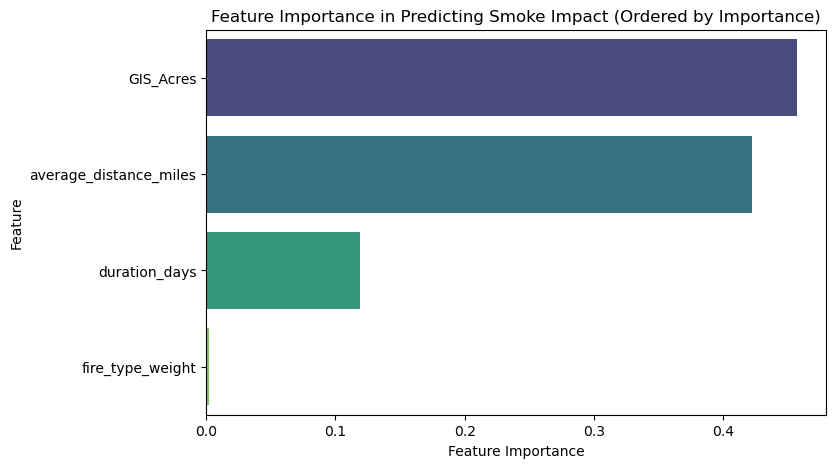

In [12]:
# Prepare data
X = distance_650[['average_distance_miles', 'fire_type_weight', 'duration_days', 'GIS_Acres']]
y = distance_650['smoke_impact']

# Scale features and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit a random forest regressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importances and create a DataFrame
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plot sorted feature importances with updated parameters for Seaborn
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis', hue='Feature', dodge=False, legend=False)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Predicting Smoke Impact (Ordered by Importance)")
plt.legend([], [], frameon=False)  # Hide legend, as it's redundant here
plt.show()

Aggregate the total smoke impact score per year

In [13]:
# Group by Year and aggregate using sum for all metrics to get total impact
annual_summary = distance_650.groupby('Fire_Year').agg({
    'smoke_impact': 'sum',
    'average_distance_miles': 'mean',  # Average distance to get typical fire distance
    'fire_type_weight': 'mean',        # Average weight to understand typical intensity
    'duration_days': 'sum',           # Total duration to capture cumulative fire days
    'GIS_Acres': 'sum'                # Total acres affected to capture total impact
}).reset_index()

annual_summary = annual_summary.rename(columns={
    'Fire_Year':        'Year',
    'smoke_impact':     'smoke_impact_sum',
    'fire_type_weight': 'fire_type_weight_mean',
    'duration_days':    'duration_days_sum',
    'GIS_Acres':        'acres_sum'})

annual_summary

,Year,smoke_impact_sum,average_distance_miles,fire_type_weight_mean,duration_days_sum,acres_sum
0,1962,0.799734,352.142859,1.000000,8.0,35.202575
1,1965,0.064886,631.837219,1.000000,19.0,6.216555
2,1967,0.000154,644.486330,1.000000,1.0,0.099457
3,1968,0.155901,358.645861,1.000000,6.0,9.318866
4,1969,0.012531,622.238696,1.000000,1.0,8.415612
5,1970,0.336888,643.247198,1.000000,7.0,30.957482
6,1971,0.250701,362.996954,1.000000,1.0,91.003736
7,1973,0.170074,637.280121,1.000000,5.0,21.677011
8,1974,0.944928,447.773052,1.000000,22.0,50.136715
9,1975,0.112755,476.795752,1.000000,9.0,14.758584


### quick timeseries visualization
okay lets quickly see our smoke impact scores over time to get an idea of trends

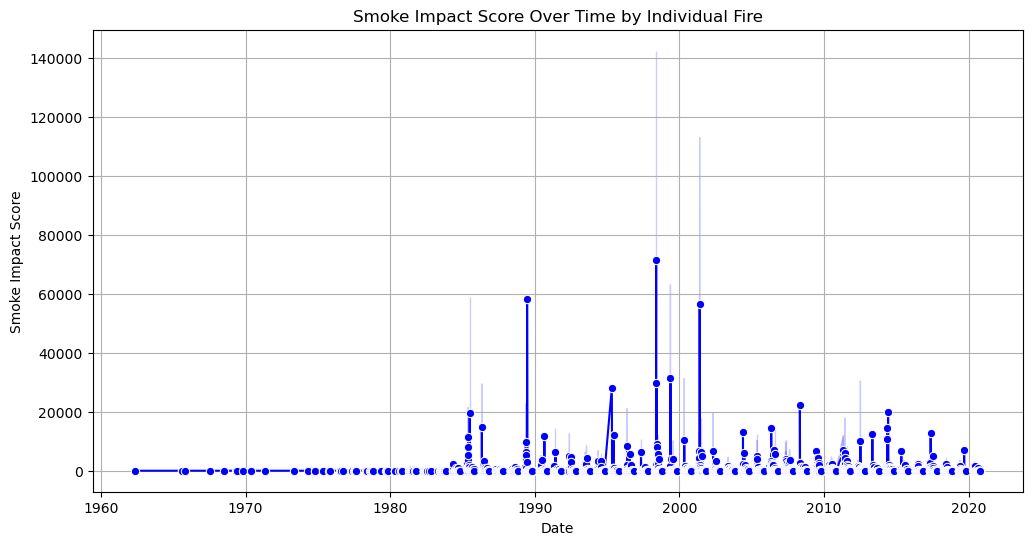

In [14]:
## BY FIRE

# Ensure 'Trusted_Start_Date' is in datetime format
distance_650['Trusted_Start_Date'] = pd.to_datetime(distance_650['Trusted_Start_Date'])

# Plotting smoke impact score over time based on Trusted_Start_Date
plt.figure(figsize=(12, 6))
sns.lineplot(data=distance_650, x='Trusted_Start_Date', y='smoke_impact', marker='o', color='b')
plt.xlabel("Date")
plt.ylabel("Smoke Impact Score")
plt.title("Smoke Impact Score Over Time by Individual Fire")
plt.grid(True)
plt.show()

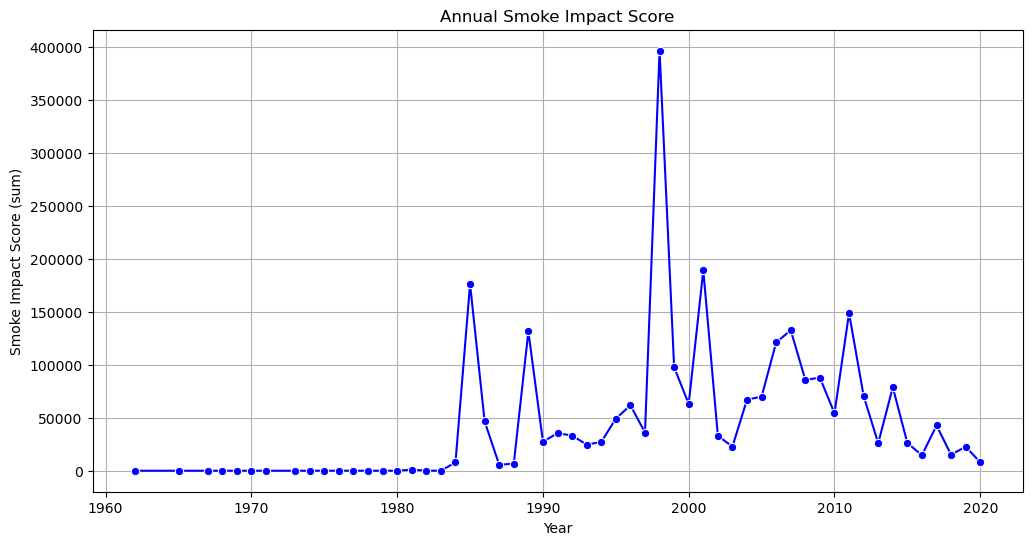

In [15]:
## BY YEAR

# Plotting smoke impact score over time based on Trusted_Start_Date
plt.figure(figsize=(12, 6))
sns.lineplot(data=annual_summary, x='Year', y='smoke_impact_sum', marker='o', color='b')
plt.xlabel("Year")
plt.ylabel("Smoke Impact Score (sum)")
plt.title("Annual Smoke Impact Score")
plt.grid(True)
plt.show()

## AQI Timeseries

We can also visualize the aqi readings over time

In [44]:
aqi_df= pd.read_csv(csv_filepath)

First lets make sure we just get a single average reading for each day

In [45]:
# Convert 'date_local' to datetime format if it's not already
aqi_df['date_local'] = pd.to_datetime(aqi_df['date_local'])

# Group by 'date_local' and calculate the mean AQI for each day
aqi_df_daily_avg = aqi_df.groupby('date_local', as_index=False)['aqi'].mean()

In [46]:
# Create the AQI DataFrame in the desired format
aqi_long = aqi_df_daily_avg[['date_local', 'aqi']].rename(columns={'date_local': 'date', 'aqi': 'value'})
aqi_long['value_type'] = 'AQI'

In [47]:
aqi_long

,date,value,value_type
0,1974-05-01,58.0,AQI
1,1974-05-02,26.5,AQI
2,1974-05-03,29.5,AQI
3,1974-05-04,41.0,AQI
4,1974-05-05,45.0,AQI
...,...,...,...
6929,2021-10-27,44.5,AQI
6930,2021-10-28,29.5,AQI
6931,2021-10-29,27.0,AQI
6932,2021-10-30,24.0,AQI


In [48]:
# Define AQI bands
aqi_bands = [
    {'label': 'Good', 'color': 'green', 'min': 0, 'max': 50},
    {'label': 'Moderate', 'color': 'yellow', 'min': 51, 'max': 100},
    {'label': 'Unhealthy for Sensitive Groups', 'color': 'orange', 'min': 101, 'max': 150},
    {'label': 'Unhealthy', 'color': 'red', 'min': 151, 'max': 200},
    {'label': 'Very Unhealthy', 'color': 'purple', 'min': 201, 'max': 300},
    {'label': 'Hazardous', 'color': 'maroon', 'min': 301, 'max': float('inf')},
]

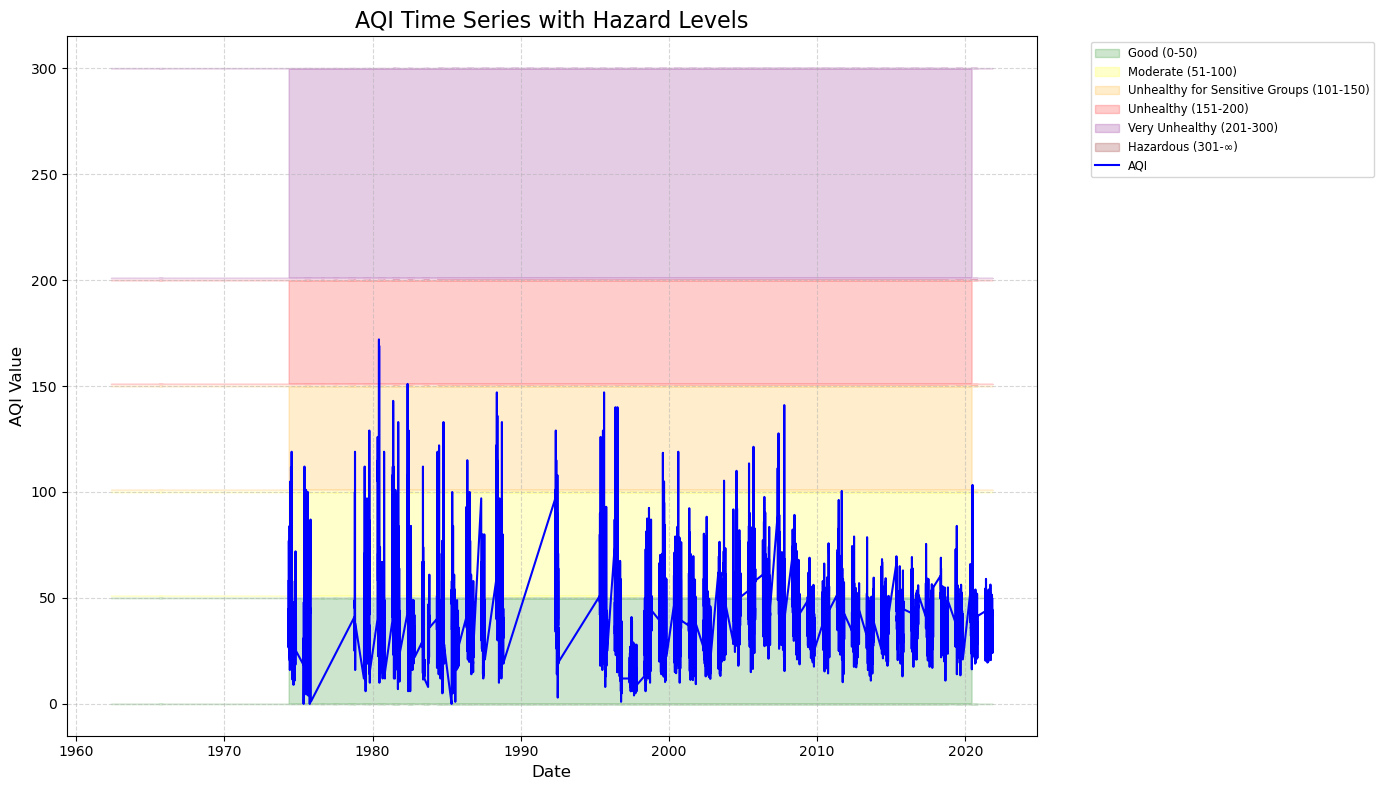

In [50]:
# Create the plot
plt.figure(figsize=(14, 8))

# Add horizontal bands for AQI hazard levels
for band in aqi_bands:
    plt.fill_between(
        combined_df['date'], 
        band['min'], 
        band['max'], 
        color=band['color'], 
        alpha=0.2, 
        label=f"{band['label']} ({band['min']}-{int(band['max']) if band['max'] < float('inf') else '∞'})"
    )

# Plot the AQI values over time
plt.plot(aqi_long['date'], aqi_long['value'], color='blue', label='AQI')

# Add labels, legend, and formatting
plt.title('AQI Time Series with Hazard Levels', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('AQI Value', fontsize=12)
plt.legend(loc='upper left', fontsize='small', bbox_to_anchor=(1.05, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the figure
output_file = "aqi_time_series_with_hazard_bands.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [60]:
# Filter for AQI >= 51 (Moderate or above)
moderate_and_above = aqi_long[aqi_long['value'] >= 51].copy()

# Add a 'year' column for grouping
moderate_and_above['Year'] = moderate_and_above['date'].dt.year

# Categorize each row into AQI bands
def categorize_aqi(value):
    for band in aqi_bands:
        if band['min'] <= value <= band['max']:
            return band['label']
    return None

moderate_and_above['aqi_band'] = moderate_and_above['value'].apply(categorize_aqi)

# Group by year and AQI band, and count the number of days in each band
days_per_band = moderate_and_above.groupby(['Year', 'aqi_band']).size().reset_index(name='days')

# Create a flat DataFrame with years and days for each band
flat_df = days_per_band.pivot(index='Year', columns='aqi_band', values='days').fillna(0).reset_index()

# Rename columns for clarity
flat_df.columns.name = None
flat_df.rename(columns={'Moderate': 'moderate_days', 
                        'Unhealthy for Sensitive Groups': 'unhealthy_sens_days', 
                        'Unhealthy': 'unhealthy_days',
                        'Very Unhealthy': 'very_unhealthy_days',
                        'Hazardous': 'hazardous_days'}, inplace=True)

# Replace NaN with 0 for missing values
flat_df = flat_df.fillna(0)

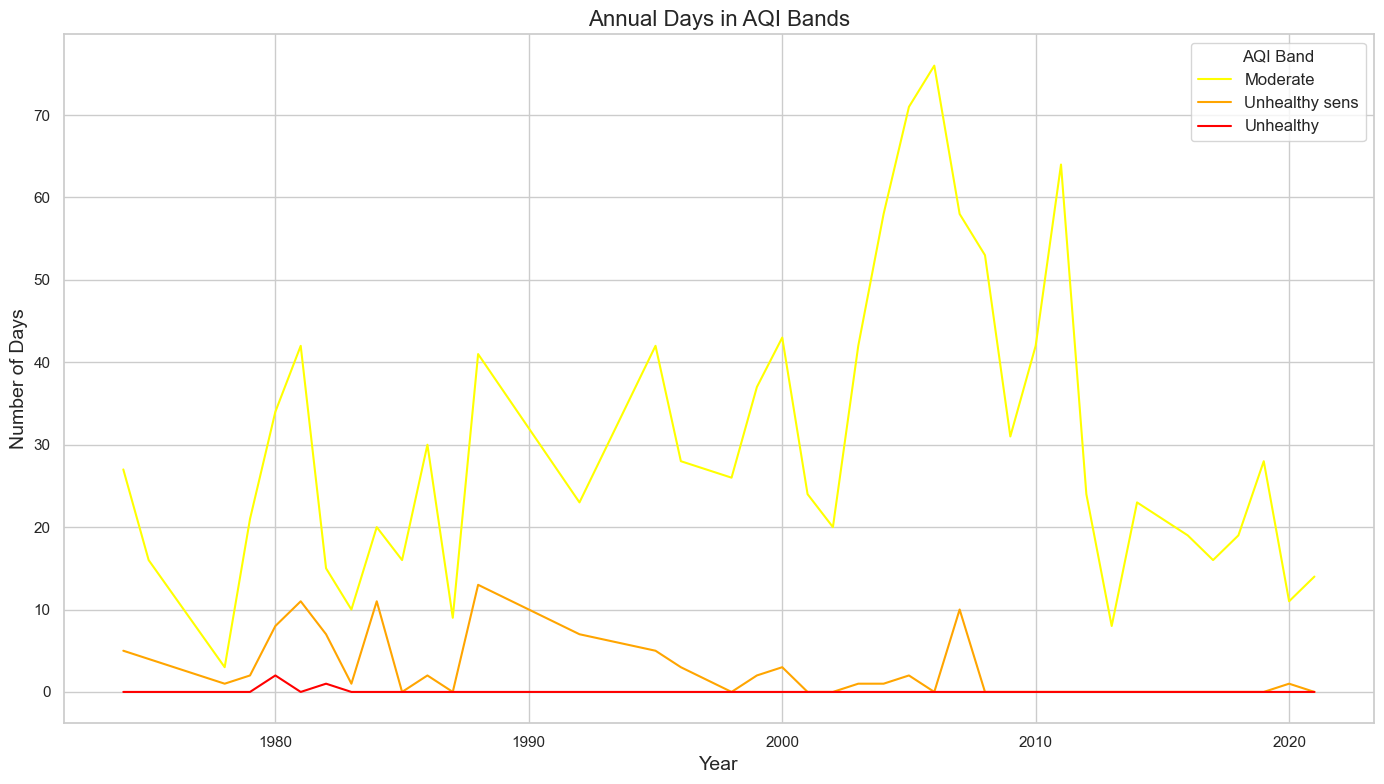

In [57]:
# Set Seaborn style
sns.set(style="whitegrid")

# Define colors for each AQI band
colors = {
    'moderate_days': 'yellow',
    'unhealthy_sens_days': 'orange',
    'unhealthy_days': 'red',
}

# Create a time series plot
plt.figure(figsize=(14, 8))

# Plot each AQI band
for column, color in colors.items():
    sns.lineplot(
        x=flat_df['year'], 
        y=flat_df[column], 
        label=column.replace('_days', '').replace('_', ' ').capitalize(), 
        color=color
    )

# Add titles and labels
plt.title('Annual Days in AQI Bands', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Days', fontsize=14)

# Add legend
plt.legend(title="AQI Band", fontsize=12)

# Display the plot
plt.tight_layout()
plt.savefig("aqi_band_timeseries_plot.png")
plt.show()

## Compare Smoke Impact Score to AQI Data

Now lets put aqi and smoke impact in the same dataframe

In [17]:
# Create the Smoke Impact DataFrame in the desired format
smoke_long = distance_650[['Trusted_Start_Date', 'smoke_impact']].rename(columns={'Trusted_Start_Date': 'date', 'smoke_impact': 'value'})
smoke_long['value_type'] = 'Smoke Impact'

# Concatenate both DataFrames
combined_df = pd.concat([aqi_long, smoke_long], ignore_index=True)

In [18]:
combined_df

,date,value,value_type
0,1974-05-01,58.000000,AQI
1,1974-05-02,26.500000,AQI
2,1974-05-03,29.500000,AQI
3,1974-05-04,41.000000,AQI
4,1974-05-05,45.000000,AQI
...,...,...,...
11596,2020-10-22,0.062086,Smoke Impact
11597,2020-10-08,0.325129,Smoke Impact
11598,2020-10-08,0.192370,Smoke Impact
11599,2020-06-01,1.262112,Smoke Impact


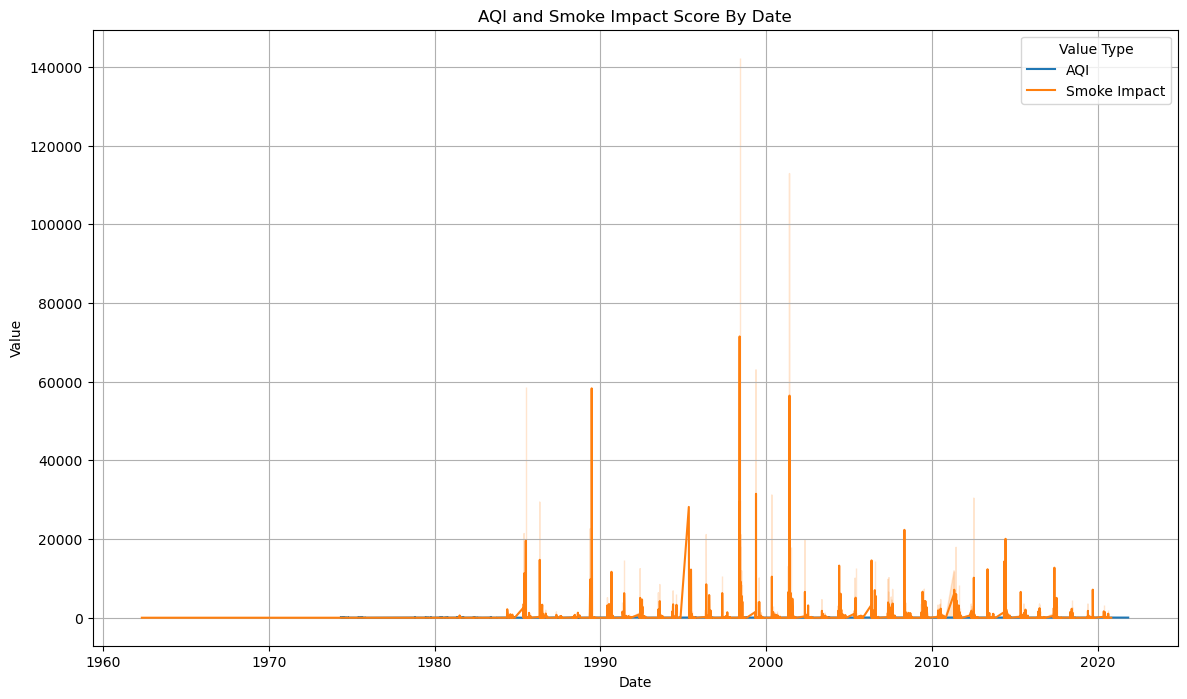

In [19]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_df, x='date', y='value', hue='value_type')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("AQI and Smoke Impact Score By Date")
plt.legend(title='Value Type')
plt.grid(True)
plt.show()

Hmm that doesnt look too great so lets normalize these so we can see them a bit better

In [20]:
# Apply z-score standardization
aqi_df_daily_avg['normalized_aqi'] = scaler.fit_transform(aqi_df_daily_avg[['aqi']])
distance_650['normalized_smoke_impact'] = scaler.fit_transform(distance_650[['smoke_impact']])

# Prepare AQI DataFrame with normalized values
aqi_long = aqi_df_daily_avg[['date_local', 'normalized_aqi']].rename(columns={'date_local': 'date', 'normalized_aqi': 'value'})
aqi_long['value_type'] = 'Normalized AQI'

# Prepare Smoke Impact DataFrame with normalized values
smoke_long = distance_650[['Trusted_Start_Date', 'normalized_smoke_impact']].rename(columns={'Trusted_Start_Date': 'date', 'normalized_smoke_impact': 'value'})
smoke_long['value_type'] = 'Normalized Smoke Impact'

# Concatenate the normalized DataFrames
combined_normalized_df = pd.concat([aqi_long, smoke_long], ignore_index=True)

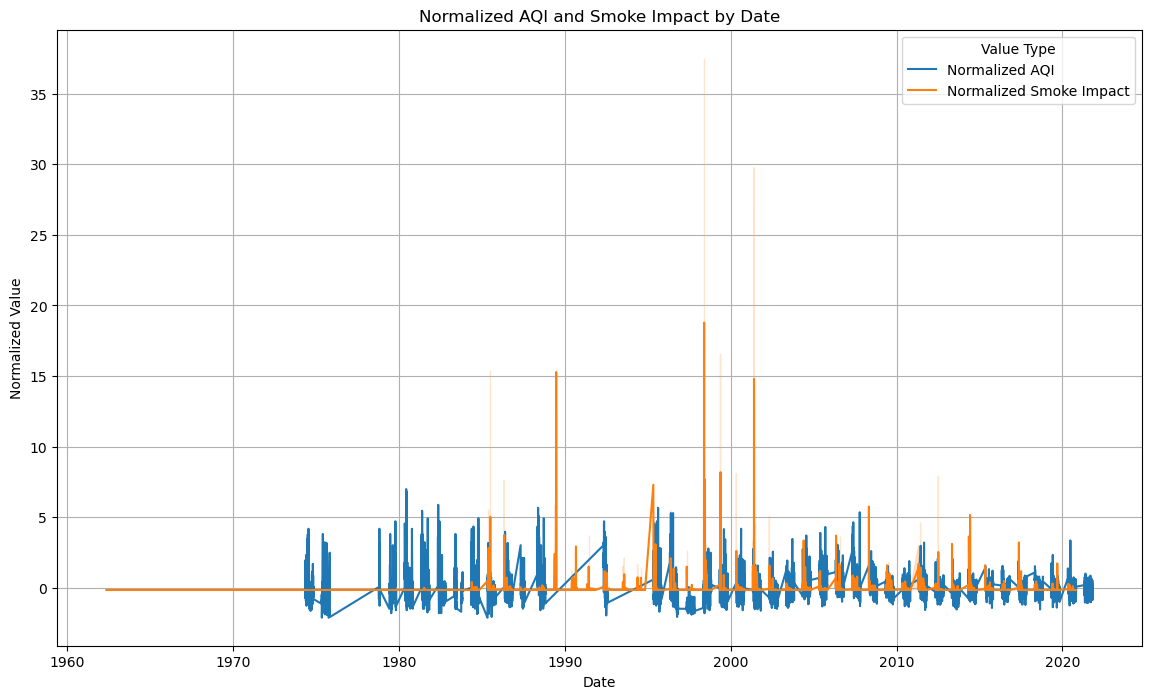

In [21]:
# Plot the normalized data
plt.figure(figsize=(14, 8))
sns.lineplot(data=combined_normalized_df, x='date', y='value', hue='value_type')
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.title("Normalized AQI and Smoke Impact by Date")
plt.legend(title='Value Type')
plt.grid(True)
plt.show()

#### Correlation score
Finally lets look at how correlated these are to see how good a job our estimated smoke impact score follows the real aqi data. 

Lets limit this to months were we have both AQI readings and fire data

In [22]:
combined_df['date'] = pd.to_datetime(combined_df['date'])

# Extract year and month to facilitate monthly aggregation
combined_df['year_month'] = combined_df['date'].dt.to_period('M')

# Aggregate by year_month and value_type to get monthly averages
monthly_avg = combined_df.groupby(['year_month', 'value_type'])['value'].mean().unstack()

# Filter months where both AQI and Smoke Impact data are present
monthly_avg = monthly_avg.dropna()

# Calculate the correlation between AQI and Smoke Impact
correlation = monthly_avg.corr().loc['AQI', 'Smoke Impact']
correlation

0.05812771082340226

The correlation score of approximately 0.058 suggests a very weak positive relationship between AQI and Smoke Impact in the overlapping monthly data. This indicates that, on average, changes in one variable are not strongly associated with changes in the other.

## Predictive Model into the future!
Lets try a few different models for our data

### ARIMA (AutoRegressive Integrated Moving Average)

**Non-Seasonal Time Series**: ARIMA, without a seasonal component, is ideal for time series where we’re interested in trends or cyclical behavior rather than fixed seasonal patterns.

**Capturing Trends and Cycles:** ARIMA can model both short-term fluctuations and long-term trends by combining differencing (to remove trends), autoregressive (AR), and moving average (MA) terms. This flexibility allows ARIMA to fit patterns in the smoke impact data, whether it’s increasing, decreasing, or fluctuating due to environmental changes or policies.

**Adaptable for Missing Years:** While ARIMA does require evenly spaced data, it’s easier to prepare for ARIMA than for seasonal models like SARIMA. You can fill in missing years by interpolation, which works well with ARIMA’s structure since the model emphasizes recent trends without needing to fit specific seasonal patterns.

**Forecasting and Interpretation:** ARIMA provides straightforward forecasts with confidence intervals, which can help predict future smoke impact scores and give you insights into uncertainty. The model's components are interpretable, allowing you to understand whether current trends are driven by historical patterns or random fluctuations.

Overall, ARIMA is a flexible and interpretable choice for forecasting non-seasonal annual data that may exhibit trends or cycles, making it a good fit for predicting future smoke impact scores based on past observations.

In [23]:
from statsmodels.tsa.arima.model import ARIMA

DATA PREP

In [25]:
# UNIVARIAT SO JUST GET SMOKE IMPACT SUM
ARIMA_data = annual_summary[["Year", "smoke_impact_sum"]].copy()

# ENSURE ALL YEARS PRESENT
# make an empty dataframe that has all the years
years = pd.date_range(start='1961', end='2021', freq='YE')
all_years_df = pd.DataFrame({
    'Year': years.year,  # Extract only the year component
    'smoke_impact_sum': [float('nan')] * len(years)
})

# Merge the two DataFrames on 'Year'
merged_df = pd.merge(all_years_df, ARIMA_data, on='Year', how='left', suffixes=('', '_original'))

# Fill NaN values from `all_years_df` with values from `model_data` where available
merged_df['smoke_impact_sum'] = merged_df['smoke_impact_sum'].fillna(merged_df['smoke_impact_sum_original'])

# Drop the temporary column
merged_df.drop(columns=['smoke_impact_sum_original'], inplace=True)

# Ensure Year is a datetime type column and that its the index
merged_df['Year'] = pd.to_datetime(merged_df['Year'], format='%Y')
merged_df['Year'] = merged_df['Year'].dt.to_period('Y')
merged_df.set_index('Year', inplace=True)

In [26]:
# Define the ARIMA model
model = ARIMA(merged_df['smoke_impact_sum'], order=(1, 1, 1))  # Start with (1, 1, 1)

# Fit the model
fitted_model = model.fit()

# Display a summary of the fitted model
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:       smoke_impact_sum   No. Observations:                   60
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -687.666
Date:                Sat, 02 Nov 2024   AIC                           1381.331
Time:                        19:08:25   BIC                           1387.564
Sample:                    12-31-1961   HQIC                          1383.764
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0231      0.393     -0.059      0.953      -0.794       0.748
ma.L1         -0.7995      0.154     -5.190      0.000      -1.101      -0.498
sigma2      5.301e+09   7.14e-11   7.43e+19      0.0

#### Interpretation of the Results

**AR (Autoregressive) and MA (Moving Average) Coefficients**:
- `ar.L1`: The autoregressive coefficient is very close to zero (-0.0231) and not statistically significant (p-value = 0.953). This suggests that the previous year’s value does not significantly contribute to predicting the current year’s `smoke_impact_sum`.

- `ma.L1`: The moving average coefficient is significant (p-value < 0.001), indicating that a short-term shock (error in the previous observation) influences the current value.
Variance (sigma2):

**Variance**
- The estimated variance (`sigma2`) is very large, which reflects high volatility in smoke_impact_sum data. This may indicate that there is substantial noise or unpredictability in the data, which is challenging for the model to capture.
Diagnostic Statistics:

**Diagnostic Statistics**
- Ljung-Box Test: The p-value for the Ljung-Box test is high (0.94), suggesting that residuals do not exhibit significant autocorrelation, which is a good sign.

- Jarque-Bera Test: The very low p-value indicates that residuals deviate significantly from a normal distribution. This, combined with high skewness and kurtosis, suggests that the data may have extreme values or outliers.

- Heteroskedasticity (H) Test: The high heteroskedasticity score points to changing variance over time, meaning that the variability of smoke_impact_sum isn’t constant, which can complicate modeling.

TL;DR: Probably not the best model for us

#### Lets Plot what it looks like at least

In [27]:
plotting_df = merged_df.copy()
plotting_df = plotting_df.reset_index().rename(columns={'index': 'Year'})
plotting_df['Year'] = plotting_df['Year'].dt.start_time
plotting_df = plotting_df.dropna(subset=['smoke_impact_sum'])

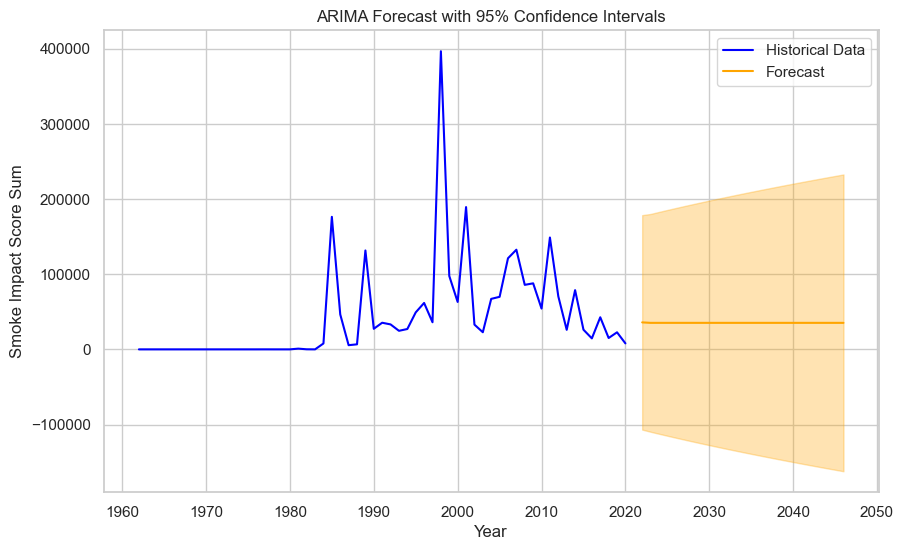

In [28]:
# Set Seaborn style
sns.set(style="whitegrid")

# Forecast for the next 5 years
forecast = fitted_model.get_forecast(steps=25)
forecast_ci = forecast.conf_int(alpha=0.05)  # 95% confidence intervals

# Plot the historical data, forecast, and confidence intervals
plt.figure(figsize=(10, 6))
sns.lineplot(x=plotting_df['Year'], y=plotting_df['smoke_impact_sum'], label='Historical Data', color ='blue' )
sns.lineplot(x=forecast.predicted_mean.index, y=forecast.predicted_mean, label='Forecast', color='orange')

# Plot confidence intervals as a shaded area
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='orange', alpha=0.3)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Smoke Impact Score Sum')
plt.title('ARIMA Forecast with 95% Confidence Intervals')
plt.legend()

# Display the plot
plt.show()

yeah that doesn't look very promising, maybe a different model will work better

### Exponential Smoothing Model
Exponential Smoothing (EMS) could be a good choice for modeling your annual_smoke_impact_df data due to the following reasons:

**Simplicity and Interpretability**: EMS is a relatively straightforward time series model, which makes it easy to interpret. This can be helpful when you want to communicate trends in the smoke impact score clearly and intuitively.

**Handling Trends**: EMS can capture both additive and multiplicative trends through models like Holt’s linear trend or damped trend models. Since your data spans many years, there might be underlying long-term trends in smoke impact due to factors like increased fire intensity, seasonal variation, or climate change.

**Smooth Forecasts for Volatile Data**: EMS provides a smoothed view of the data, which is particularly useful if you’re dealing with volatility or noise in annual values. It can help create a forecast that highlights the underlying pattern without being overly affected by year-to-year fluctuations.

**Flexibility with Seasonality**: While this data is annual, EMS can still model data with seasonality if needed, making it flexible for future adjustments if more granular data (e.g., monthly) is analyzed.

**Adaptability to Changing Trends**: EMS models can place more weight on recent observations if the data changes over time. This can be beneficial for datasets impacted by evolving factors, such as changes in fire management practices or environmental conditions impacting smoke severity.

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DATA PREP

In [30]:
ESM_data = annual_summary[["Year", "smoke_impact_sum"]].copy()

Looks like I'm missing a few years right at the beginning so I need to fill those gaps in the index and put the smoke index at nan

In [31]:
# make an empty dataframe that has all the years
years = pd.date_range(start='1961', end='2021', freq='YE')
all_years_df = pd.DataFrame({
    'Year': years.year,  # Extract only the year component
    'smoke_impact_sum': [float('nan')] * len(years)
})

# Merge the two DataFrames on 'Year'
merged_df = pd.merge(all_years_df, ESM_data, on='Year', how='left', suffixes=('', '_original'))

# Fill NaN values from `all_years_df` with values from `model_data` where available
merged_df['smoke_impact_sum'] = merged_df['smoke_impact_sum'].fillna(merged_df['smoke_impact_sum_original'])

# Drop the temporary column
merged_df.drop(columns=['smoke_impact_sum_original'], inplace=True)

In [32]:
merged_df['Year'] = pd.to_datetime(merged_df['Year'], format='%Y')
merged_df['Year'] = merged_df['Year'].dt.to_period('Y')
merged_df.set_index('Year', inplace=True)

SET UP THE MODEL

In [33]:
# Set up and fit the Exponential Smoothing model
model = ExponentialSmoothing(
    merged_df['smoke_impact_sum'], 
    trend='add',        
    damped_trend=True,   # Add damping to the trend
    seasonal=None,      
    initialization_method="legacy-heuristic"
)

fitted_model = model.fit()

C:\anaconda\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Well that failed, we can try a couple other models

## Vector Autoregression (VAR)

Vector Autoregression (VAR) is well-suited for multivariate time series data where multiple variables may influence each other over time. 

Since our data includes multiple fire-related metrics (e.g., smoke_impact_sum, average_distance_miles, fire_type_weight, duration_days, GIS_Acres), VAR allows us to model the interdependencies among these variables. For example, we might want to understand how changes in fire acreage or fire duration affect the smoke impact score.

Key Advantages of VAR for this dataset:

**Capturing Relationships Between Variables**: VAR can model the interactions between multiple time series, such as how changes in fire size or intensity impact smoke levels. This is beneficial if there is a feedback loop where variables affect each other.

**Handling Lagged Effects**: VAR models can capture how past values of each variable influence future values of both itself and the other variables, which is especially useful if there are delayed effects of fires on smoke impact.

In [68]:
from statsmodels.tsa.api import VAR

In [83]:
VAR_data = annual_summary.copy()

# Years need to be continuous for VAR to work, so we are going to subset to 
# after 1973 when our data becomes continuous
VAR_data_subset = VAR_data[VAR_data['Year'] >= 1973].copy()

# Ensure Year is a datetime type column and that its the index
VAR_data_subset['Year'] = pd.to_datetime(VAR_data_subset['Year'], format='%Y')
VAR_data_subset['Year'] = VAR_data_subset['Year'].dt.to_period('Y')
VAR_data_subset.set_index('Year', inplace=True)

In [84]:
# Instantiate and fit the VAR model
model = VAR(VAR_data_subset)
fitted_model = model.fit()

# Display model summary to examine coefficients and lag order
print(fitted_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Nov, 2024
Time:                     23:33:39
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    62.4097
Nobs:                     47.0000    HQIC:                   61.6731
Log likelihood:          -1742.33    FPE:                3.92957e+26
AIC:                      61.2287    Det(Omega_mle):     2.15504e+26
--------------------------------------------------------------------
Results for equation smoke_impact_sum
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                         62198.762361    264615.715319            0.235           0.814
L1.smoke_impact_sum               0.076159         0.218853            0.348           0.728
L

**Coefficients and Significance:**

- `smoke_impact_sum` (L1): The coefficient for smoke_impact_sum itself (lagged by 1 year) is positive but has a high p-value (0.728), meaning it is not statistically significant. This indicates that the previous year’s smoke impact score is not a strong predictor of the current year’s smoke impact score.

- `fire_type_weight_mean`, `duration_days_sum`, and `acres_sum`: None of these coefficients are significant for predicting `smoke_impact_sum`, based on their high p-values (all greater than 0.05). This suggests that in this model configuration, there is little direct predictive relationship between `smoke_impact_sum` and these lagged variables.

**Correlation Matrix of Residuals**:

- The residual correlation matrix shows correlations between the unexplained parts (residuals) of each equation. Notably:
smoke_impact_sum has a relatively high positive correlation with acres_sum (0.683), suggesting that these variables may have an underlying relationship not fully captured by the model.

- There is also a notable correlation between smoke_impact_sum and duration_days_sum (0.587), which could indicate some dependency.

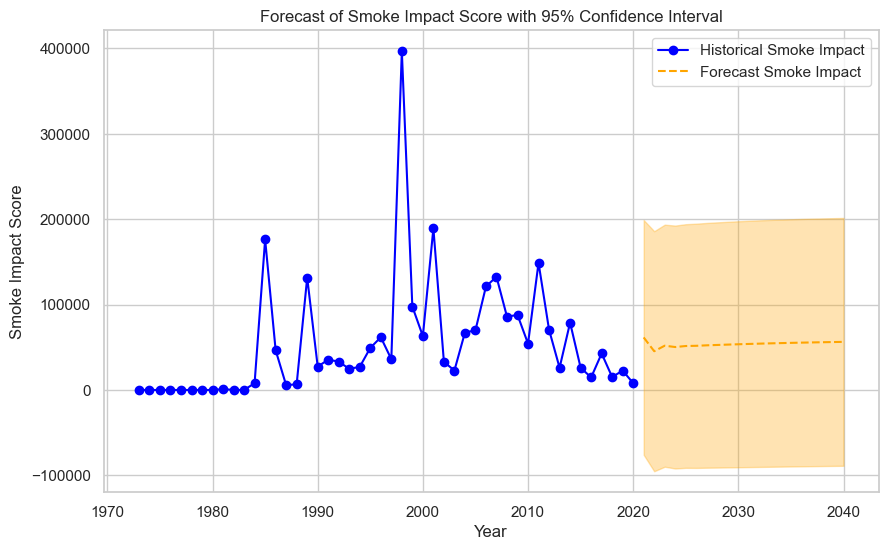

In [37]:
# Define forecast period (e.g., 5 years)
forecast_steps = 20

# Generate forecast and confidence intervals for all variables
forecast, lower_bound, upper_bound = fitted_model.forecast_interval(VAR_data_subset.values[-fitted_model.k_ar:], steps=forecast_steps)

# Convert forecast and confidence intervals to DataFrames
# Convert the last index value to a timestamp
forecast_start = VAR_data_subset.index[-1].to_timestamp() + pd.offsets.YearEnd(1)
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='YE')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=VAR_data_subset.columns)
lower_bound_df = pd.DataFrame(lower_bound, index=forecast_index, columns=VAR_data_subset.columns)
upper_bound_df = pd.DataFrame(upper_bound, index=forecast_index, columns=VAR_data_subset.columns)

# Plot only the 'smoke_impact_sum' historical data and forecast with confidence intervals
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(VAR_data_subset.index.to_timestamp(), VAR_data_subset['smoke_impact_sum'], label='Historical Smoke Impact', marker='o', color='blue')

# Plot forecast data
plt.plot(forecast_df.index, forecast_df['smoke_impact_sum'], label='Forecast Smoke Impact', linestyle='--', color='orange')

# Plot confidence intervals for the forecast
plt.fill_between(forecast_df.index, 
                 lower_bound_df['smoke_impact_sum'], 
                 upper_bound_df['smoke_impact_sum'], 
                 color='orange', alpha=0.3)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Smoke Impact Score')
plt.title('Forecast of Smoke Impact Score with 95% Confidence Interval')
plt.legend()

# Show the plot
plt.show()

#### Implementation 2

In [91]:
VAR_data2 = pd.merge(annual_summary, flat_df, on='Year', how='outer')

VAR_data_subset = VAR_data[VAR_data['Year'] >= 1998].copy()

# Ensure Year is datetime and set as index
VAR_data_subset['Year'] = pd.to_datetime(VAR_data_subset['Year'], format='%Y')
VAR_data_subset['Year'] = VAR_data_subset['Year'].dt.to_period('Y')
VAR_data_subset.set_index('Year', inplace=True)

In [92]:
# Instantiate and fit the VAR model
model = VAR(VAR_data_subset)
fitted_model = model.fit()

# Display model summary
print(fitted_model.summary())

In [94]:
# Forecast next 20 periods (20 years in this case)
forecast_steps = 20
forecast, lower_bound, upper_bound = fitted_model.forecast_interval(
    VAR_data_subset.values[-fitted_model.k_ar:], 
    steps=forecast_steps
)

# Convert forecast and bounds to DataFrames
forecast_start = VAR_data_subset.index[-1].to_timestamp() + pd.offsets.YearEnd(1)
forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='YE')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=VAR_data_subset.columns)
lower_bound_df = pd.DataFrame(lower_bound, index=forecast_index, columns=VAR_data_subset.columns)
upper_bound_df = pd.DataFrame(upper_bound, index=forecast_index, columns=VAR_data_subset.columns)

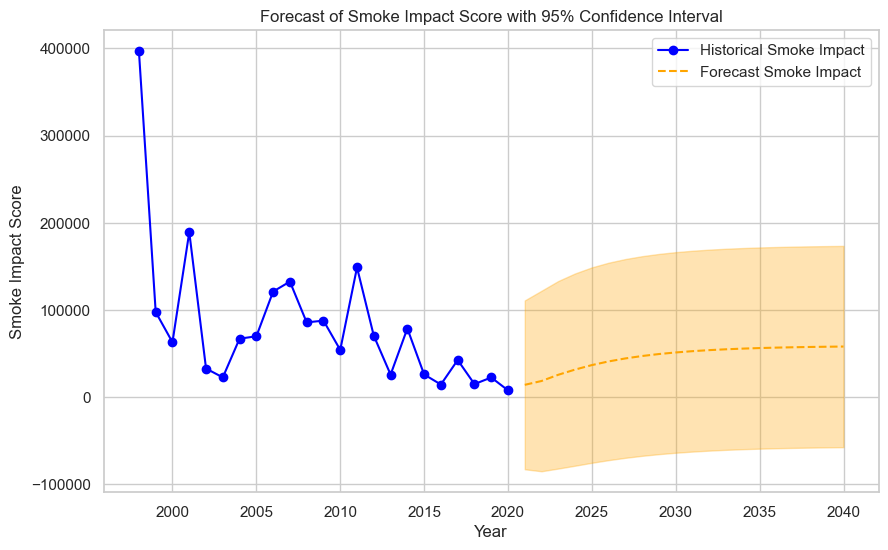

In [95]:
# Plot only the 'smoke_impact_sum' historical data and forecast with confidence intervals
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(VAR_data_subset.index.to_timestamp(), VAR_data_subset['smoke_impact_sum'], label='Historical Smoke Impact', marker='o', color='blue')

# Plot forecast data
plt.plot(forecast_df.index, forecast_df['smoke_impact_sum'], label='Forecast Smoke Impact', linestyle='--', color='orange')

# Plot confidence intervals for the forecast
plt.fill_between(forecast_df.index, 
                 lower_bound_df['smoke_impact_sum'], 
                 upper_bound_df['smoke_impact_sum'], 
                 color='orange', alpha=0.3)

# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Smoke Impact Score')
plt.title('Forecast of Smoke Impact Score with 95% Confidence Interval')
plt.legend()

# Show the plot
plt.show()

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

kernel = C(1.0) * RBF(1.0)  # Example kernel
model = GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
model.fit(X_train, y_train)
y_pred, y_std = model.predict(X_test, return_std=True)

C:\anaconda\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


#### Polynomial Regression

**Benefits**
**Capturing Curved Relationships:**
- If the relationship between smoke_impact_sum and any predictor is nonlinear, polynomial regression can help. For example, smoke_impact_sum might not increase linearly with acres_sum; instead, the impact might escalate at a faster rate, which a polynomial term (e.g., acres_sum^2) can capture.
Flexibility:

- By including squared or cubic terms, polynomial regression becomes flexible enough to model complex relationships that linear regression would miss. This flexibility can improve model fit and predictive accuracy, especially if higher-order interactions between predictors are meaningful.
Feature Interactions:

- Polynomial regression inherently includes interaction terms when using multiple predictors (e.g., average_distance_miles * duration_days_sum), which may capture important dependencies. This can help model cases where the impact of one predictor depends on the value of another.

**Drawbacks**
Risk of Overfitting:

- Polynomial regression can easily overfit, especially with high-degree polynomials or a small dataset. Overfitting happens when the model becomes too tailored to the training data, capturing noise rather than the actual relationship, which can reduce predictive performance on new data.
Reduced Interpretability:

- The more polynomial terms you add, the harder it becomes to interpret individual coefficients. For example, understanding the effect of duration_days_sum^2 or acres_sum^3 on smoke_impact_sum can be challenging, and it may be unclear how each predictor contributes independently.
Potential Instability with High Degrees:

- Higher-degree polynomial models can become numerically unstable, especially if the data has outliers or if certain variables vary widely in scale. This can lead to erratic predictions, especially in regions where the data is sparse.

**No Temporal Component:**
If smoke_impact_sum depends on past values of the predictors (temporal relationships), polynomial regression will miss these dependencies since it considers only contemporaneous relationships.

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
poly_data = annual_summary.copy()

In [41]:
# Select predictors and target variable
X = poly_data[['average_distance_miles', 'fire_type_weight_mean', 'duration_days_sum', 'acres_sum']]
y = poly_data['smoke_impact_sum']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

 Create Polynomial Features and Fit the Model

In [42]:
# Define the polynomial degree (e.g., degree 2 for quadratic relationships)
degree = 2

# Create a pipeline that generates polynomial features and then fits a linear regression model
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

Evaluate the Model

In [43]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 7280854696.56836
R-squared: 0.439309298158563


**Mean Squared Error (MSE)**: 7280854696.56836
This value represents the average squared difference between the predicted and actual values. A high MSE suggests that there is a significant discrepancy between our predictions and the actual smoke_impact_sum values. The smoke impact values are pretty large, so this might be more reasonable than we would first think, but this is still not good.

**R-squared**: 0.4393
This means that approximately 43.9% of the variance in smoke_impact_sum is explained by the polynomial regression model with the chosen predictors and degree. While an R-squared value of around 0.44 indicates that the model is capturing some of the pattern in the data, it suggests that more than half of the variance remains unexplained.

In [44]:
# Summary statistics for `smoke_impact_sum`
smoke_impact_summary = VAR_data_subset['smoke_impact_sum'].describe()

print(smoke_impact_summary)

count        48.000000
mean      53044.739263
std       70472.803707
min           0.000253
25%        6421.610017
50%       30166.776069
75%       70101.157277
max      396766.923409
Name: smoke_impact_sum, dtype: float64


#### Visualize: 

this model can't produce 95% confidence intervals so instead we will do a scatter plot of actual vs predicted values

These plots are commonly used in regression analysis to assess the performance of a model by visually comparing the predicted values (fitted values) with the actual observations (observed values). If the model is accurate, the points should cluster around a 45-degree line where the predicted values equal the actual values.

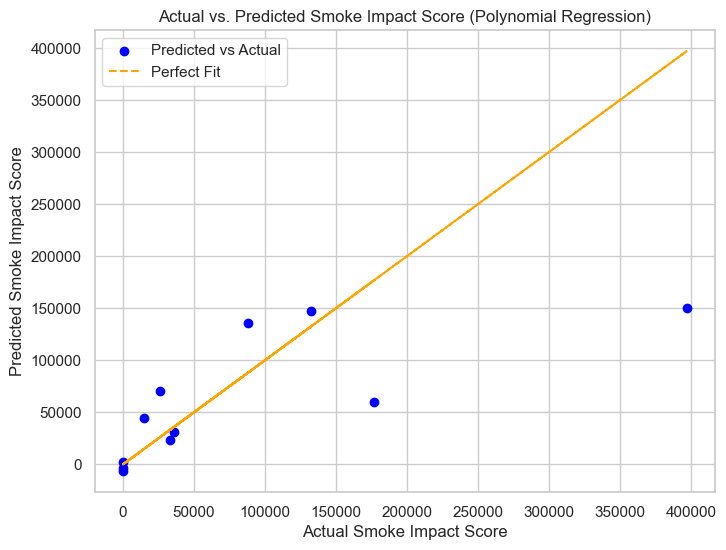

In [45]:
# Scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.plot(y_test, y_test, color='orange', linestyle='--', label='Perfect Fit')

plt.xlabel("Actual Smoke Impact Score")
plt.ylabel("Predicted Smoke Impact Score")
plt.title("Actual vs. Predicted Smoke Impact Score (Polynomial Regression)")
plt.legend()
plt.show()

### Random Forest Regression

In [23]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [70]:
# Prepare the data
model_data = pd.merge(annual_summary, flat_df, on='Year', how='outer')
model_data['Year'] = pd.to_datetime(model_data['Year'], format='%Y')
model_data.set_index('Year', inplace=True)

In [78]:
# Prepare features (independent variables) and target (dependent variable)
X = model_data[['average_distance_miles', 'fire_type_weight_mean', 'duration_days_sum', 'acres_sum',
                'moderate_days', 'unhealthy_days', 'unhealthy_sens_days']].fillna(0)
y = model_data['smoke_impact_sum'].fillna(0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance for understanding
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

In [79]:
# Forecasting
forecast_steps = 10
forecast_years = pd.date_range(start=model_data.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')

forecast = []
last_row = X.iloc[-1]
for _ in range(forecast_steps):
    prediction = rf.predict(last_row.values.reshape(1, -1))[0]
    forecast.append(prediction)
    # Simulate future predictors based on trends
    last_row['average_distance_miles'] = last_row['average_distance_miles']  # Adjust if trend is known
    last_row['fire_type_weight_mean'] = last_row['fire_type_weight_mean']
    last_row['duration_days_sum'] = last_row['duration_days_sum']
    last_row['acres_sum'] = last_row['acres_sum']
    last_row['moderate_days'] = last_row['moderate_days']
    last_row['unhealthy_days'] = last_row['unhealthy_days']
    last_row['unhealthy_sens_days'] = last_row['unhealthy_sens_days']

# Convert forecast to DataFrame
forecast_df = pd.DataFrame({'Year': forecast_years, 'Forecast': forecast})
forecast_df.set_index('Year', inplace=True)

C:\Users\clark.roll\AppData\Local\Temp\ipykernel_23420\1850359116.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_years = pd.date_range(start=model_data.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='Y')
C:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\clark.roll\AppData\Local\Temp\ipykernel_23420\1850359116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_row['average_distance_miles'] = last_row['average_distance_miles']  # Adjust if trend is known
C:\Users\clark.roll\AppData\Local\Temp\ipykernel_23420\1850359116.py:12: SettingWithCopyWarning: 
A value is trying to be set on 

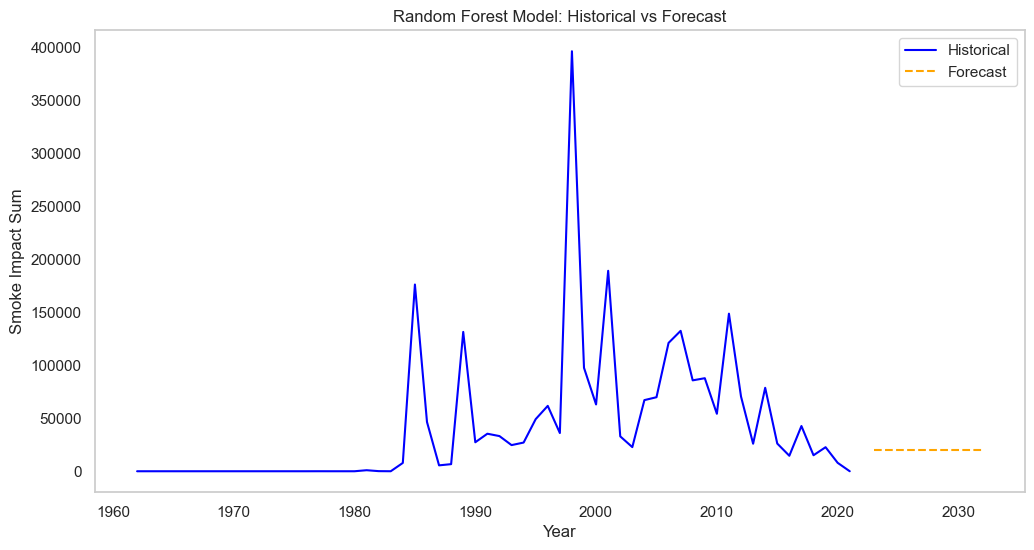

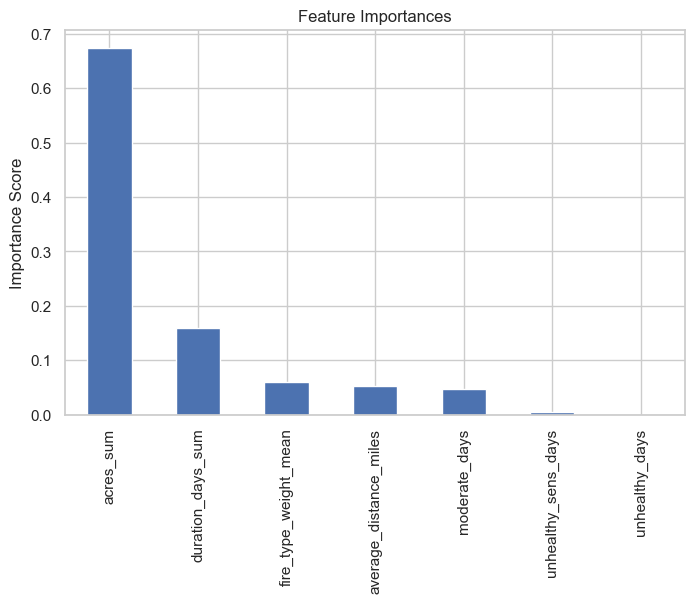

In [80]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(model_data.index, y, label='Historical', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='orange', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Sum')
plt.title('Random Forest Model: Historical vs Forecast')
plt.legend()
plt.grid()
plt.show()

# Feature importance plot
plt.figure(figsize=(8, 5))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.ylabel('Importance Score')
plt.show()

In [37]:
# Forecast future values (using the most recent values for predictors)
last_row = X.iloc[-1]  # Get the last row of features for predictions
forecast_steps = 10
forecast_years = pd.date_range(start=model_data.index[-1] + pd.DateOffset(years=1), periods=forecast_steps, freq='YE')

forecast = []
for _ in range(forecast_steps):
    # Reshape last_row as a DataFrame to retain feature names
    last_row_df = pd.DataFrame([last_row], columns=X.columns)
    prediction = rf.predict(last_row_df)[0]
    forecast.append(prediction)

    # Update the last_row values (optional: adjust trends if necessary)
    last_row['average_distance_miles'] = last_row['average_distance_miles']
    last_row['fire_type_weight_mean'] = last_row['fire_type_weight_mean']
    last_row['duration_days_sum'] = last_row['duration_days_sum']
    last_row['acres_sum'] = last_row['acres_sum']

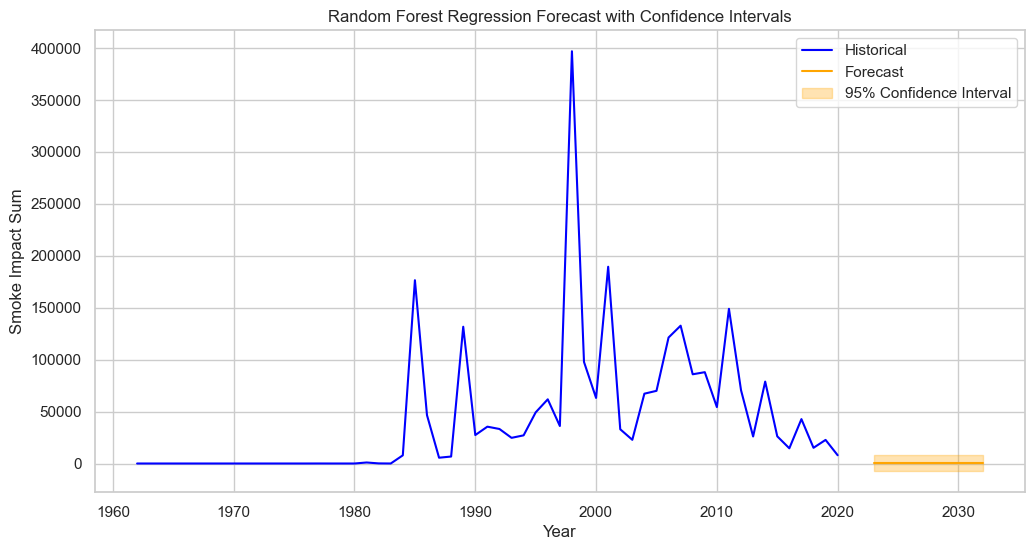

In [73]:
# Plot historical data and forecasted values with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(model_data.index, model_data['smoke_impact_sum'], label='Historical', color='blue')
plt.plot(forecast_years, forecast, label='Forecast', color='orange')
plt.fill_between(forecast_years, lower_bounds, upper_bounds, color='orange', alpha=0.3, label='95% Confidence Interval')

# Add labels and legend
plt.title('Random Forest Regression Forecast with Confidence Intervals')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Sum')
plt.legend()
plt.show()

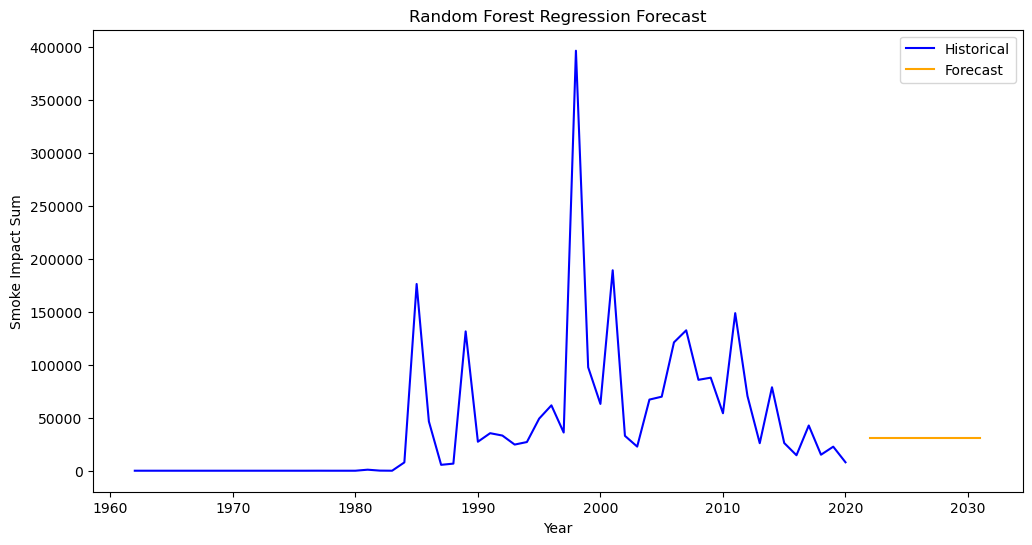

In [34]:
# Plot historical data and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(model_data.index, model_data['smoke_impact_sum'], label='Historical', color='blue')
plt.plot(forecast_years, forecast, label='Forecast', color='orange')

# Add labels and legend
plt.title('Random Forest Regression Forecast')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Sum')
plt.legend()
plt.show()